# Steps to solve Emergency vs Non-Emergency vehicle classification problem

<ol>1. Loading the Dataset</ol>
<ol>2. Pre-processing the Data</ol>
<ol>3. Creating Training and Validation set</ol>
<ol>4. Defining the Model Architecture</ol>
<ol>5. Compiling the model (Defining loss function, optimizer)</ol>
<ol>6. Training the Model</ol>
<ol>7. Evaluating Model Performance</ol>
<ol>8. Hyperparameter Tuning</ol>

## 1. Loading the dataset

In [ ]:
#mounting the drive
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


In [ ]:
#extract the images
!unzip '/content/drive/MyDrive/AV/Course_Handouts_Fundamentals_of_Deep_Learning/Dataset.zip' 

Archive:  /content/drive/MyDrive/AV/Course_Handouts_Fundamentals_of_Deep_Learning/Dataset.zip
   creating: Dataset/
  inflating: Dataset/emergency_classification.csv  
   creating: Dataset/images/
  inflating: Dataset/images/0.jpg    
  inflating: Dataset/images/10.jpg   
  inflating: Dataset/images/1002.jpg  
  inflating: Dataset/images/1006.jpg  
  inflating: Dataset/images/1007.jpg  
  inflating: Dataset/images/1009.jpg  
  inflating: Dataset/images/1013.jpg  
  inflating: Dataset/images/1014.jpg  
  inflating: Dataset/images/1016.jpg  
  inflating: Dataset/images/1019.jpg  
  inflating: Dataset/images/102.jpg  
  inflating: Dataset/images/1020.jpg  
  inflating: Dataset/images/1022.jpg  
  inflating: Dataset/images/1023.jpg  
  inflating: Dataset/images/1026.jpg  
  inflating: Dataset/images/1031.jpg  
  inflating: Dataset/images/1035.jpg  
  inflating: Dataset/images/1036.jpg  
  inflating: Dataset/images/1037.jpg  
  inflating: Dataset/images/104.jpg  
  inflating: Dataset/images

In [4]:
# importing the required libraries
%matplotlib inline
import numpy as np  
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# importing libraries for defining the architecture of model
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Sigmoid, Dropout, BatchNorm1d, Conv2d, MaxPool2d, BatchNorm2d

In [5]:
#reading a csv file
data = pd.read_csv('Dataset/emergency_classification.csv') 

In [6]:
# creating a random seed
seed = 42

In [7]:
#first 5 rows
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


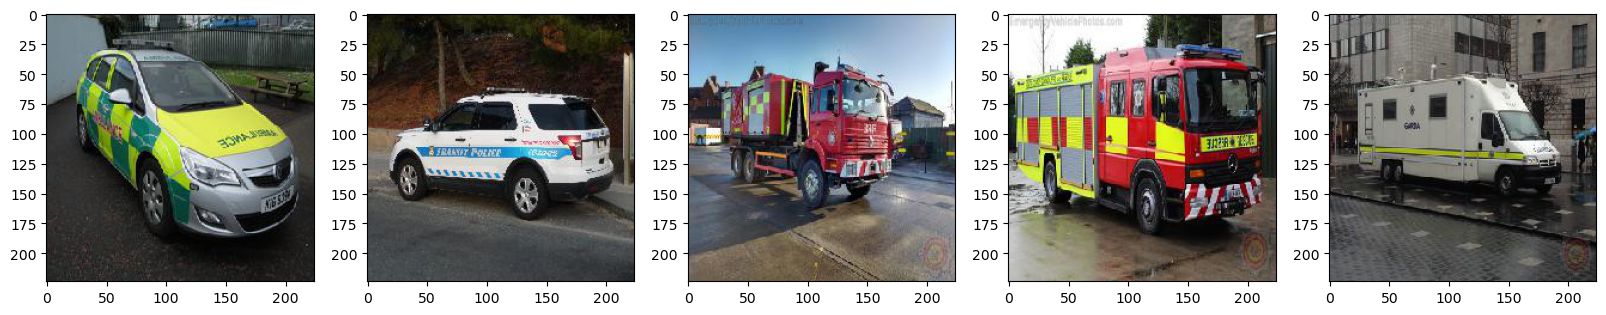

In [8]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:
    # loading the image using its name
    img = plt.imread('Dataset/images/' + img_name)
    # normalizing the pixel values
    img = img / 255
    # saving each image in the list
    X.append(img)
    
# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

#Glance at the images
fig, axes = plt.subplots(ncols=5,figsize=(20,10))
for i in range(5):
  axes[i].imshow(X[i])

## 2. Pre-processing the Data

In [9]:
# shape of images
X.shape

(2352, 224, 224, 3)

In [10]:
#reshaping array as pytorch acceps channels as the first dimension of an image
X = np.moveaxis(X, -1, 1)  
X.shape

(2352, 3, 224, 224)

## 3. Creating Training and Validation set

In [11]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed, stratify=y)

In [12]:
# shape of training and validation set
(X_train.shape, y_train.shape), (X_valid.shape, y_valid.shape)

(((1646, 3, 224, 224), (1646,)), ((706, 3, 224, 224), (706,)))

In [13]:
# converting training and validation set to PyTorch tensor

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

X_valid = torch.FloatTensor(X_valid)
y_valid = torch.FloatTensor(y_valid)

## 4. Defining the model architecture

In [14]:
# Define CNN architecture

# Input 
# Conv2d(64, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride=2)
# Conv2d(128, kernel_size=(3, 3), stride=(1, 1), 'relu')
# MaxPool2d((2, 2), stride=2)
# Linear(64, 'relu')
# Linear(1, 'sigmoid')

class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      #define the convolution block
      self.conv_layers = Sequential(
         
         #[bs,3,224,224] 
         Conv2d(in_channels=3, out_channels=64, kernel_size=3),
         
         #[bs,64,222,222]
         ReLU(),
         
         #[bs,64,222,222]
         MaxPool2d(kernel_size=2, stride=2),
         
         #[bs,64,111,111]
         Conv2d(64, 128, 3),

         #[bs,128,109,109]
         ReLU(),

         #[bs,128,109,109]
         MaxPool2d(2, 2)          
         
         )
      
      # input -> [bs,3,224,224] 
      # Conv2d(64, kernel_size=(3, 3), stride=(1, 1), 'relu') -> [bs,64,222,222]
      # MaxPool2d((2, 2), stride=2) -> [bs,64,111,111]
      # Conv2d(128, kernel_size=(3, 3), stride=(1, 1), 'relu') -> [bs,128,109,109]
      # MaxPool2d((2, 2), stride=2) -> [bs,128,54,54]
      # Flatten -> [bs, 128*54*54]


      #define the dense block   
      self.linear_layers=Sequential(
           
           #[bs,128*54*54]
           Linear(128 * 54 * 54, 64),

           #[bs,128*54*54]
           ReLU(),

           #[bs,64]
           Linear(64, 1),
           
           #[bs,1]
           Sigmoid()
       )
  
  #Defining the forward pass    
  def forward(self, x):
    
    #convolution block
    x = self.conv_layers(x)
    
    #flattening the output
    x = x.reshape(x.size(0),-1)
    
    #dense block
    x = self.linear_layers(x)
    
    return x

## 5. Compiling the model (defining loss function, optimizer)

In [15]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()

#define optimizer and loss
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=373248, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


## 6. Training the model

In [18]:
# batch size of the model
batch_size = 64


for epoch in tqdm(range(5)):
    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in range(0,X_train.size()[0], batch_size):
        model.train()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        # batch computation

        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # batch computation
        outputs = model(batch_x)
        outputs = outputs.squeeze()
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

 20%|██        | 1/5 [01:34<06:16, 94.03s/it]

epoch: 	 0 	 training loss: 	 0.6636150571016165


100%|██████████| 5/5 [08:02<00:00, 96.54s/it]


## 7. Evaluating model performance

In [20]:
# prediction for training set
train_prediction = []
train_target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()
    
    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

100%|██████████| 26/26 [00:25<00:00,  1.01it/s]


In [21]:
# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))
    
print('training accuracy: \t', np.average(training_accuracy))

training accuracy: 	 0.8594272575250836


In [23]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()
    
    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

100%|██████████| 12/12 [00:11<00:00,  1.07it/s]


In [24]:
# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))
    
print('validation accuracy: \t', np.average(valid_accuracy))

validation accuracy: 	 0.7734375


## 8. Hyperparameter Tuning

In [25]:
# defining the architecture of the model

# Input()
# Conv2d(64, kernel_size=(3, 3), stride=(1, 1))
# BatchNorm2d()
# ReLU()
# MaxPool2d(kernel_size=2, stride=2)
# Conv2d(128, kernel_size=(3, 3), stride=(1, 1))
# BatchNorm2d()
# ReLU()
# MaxPool2d(kernel_size=2, stride=2)
# Conv2d(128, kernel_size=(5, 5), stride=(1, 1))
# BatchNorm2d()
# ReLU()
# MaxPool2d(kernel_size=2, stride=2)
# Conv2d(256, kernel_size=(5, 5), stride=(1, 1))
# BatchNorm2d()
# ReLU()
# MaxPool2d(kernel_size=2, stride=2)
# Flatten()
# Linear(64, 'relu')
# Dropout(p=0.6)
# Linear(out_features=1, 'sigmoid')

class Net(nn.Module):   
  def __init__(self):
      super(Net, self).__init__()

      #define the convolution block
      self.conv_layers = Sequential(
         
         #[bs,3,224,224]
         Conv2d(in_channels=3, out_channels=64, kernel_size=3),
         
         #[bs,64,222,222]
         BatchNorm2d(num_features=64),
         
         #[bs,64,222,222]
         ReLU(),
                 
         #[bs,64,222,222]
         MaxPool2d(kernel_size=2, stride=2),

         #[bs,64,111,111]
         Conv2d(64, 128, 3),

         #[bs,128,109,109]         
         BatchNorm2d(num_features=128),
         
         #[bs,128,109,109]
         ReLU(),
         
         #[bs,128,109,109]
         MaxPool2d(2, 2), 
         
         #[bs,128,54,54]
         Conv2d(128, 128, 5),
         
         #[bs,128,54,54]
         BatchNorm2d(num_features=128),
         
         #[bs,128,54,54]
         ReLU(),
         
         #[bs,128,54,54]
         MaxPool2d(2, 2), 

         #[bs,128,25,25] 
         Conv2d(128, 256, 5),
         
         #[bs,256,21,21]
         BatchNorm2d(num_features=256),
         
         ReLU(),
         
         MaxPool2d(2, 2)              
         )
      
      self.linear_layers=Sequential(
           
           #[bs,10*10*256]
           Linear(10 * 10 * 256, 64),
           
           #[bs,64]
           ReLU(),
           
           Dropout(0.6),
           
           #[bs,64]
           Linear(64, 1),
           
           #[bs,1]
           Sigmoid()
       )
  
  # Defining the forward pass    
  def forward(self, x):
    
    #convolution block
    x = self.conv_layers(x)
    
    #flattening
    x = x.reshape(x.size(0),-1)
    
    #dense block
    x = self.linear_layers(x)
    
    return x

In [26]:
# for same default initialization
torch.manual_seed(32)

# defining the model
model = Net()

#define optimizer and loss
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, p

In [27]:
import torch
torch.cuda.empty_cache()

In [30]:
# batch size of the model
batch_size = 128

for epoch in tqdm(range(5)):
    # keep track of training 
    train_loss = 0.0
        
    permutation = torch.randperm(X_train.size()[0])

    training_loss = []
    for i in range(0,X_train.size()[0], batch_size):
        model.train()
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train[indices], y_train[indices]
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # batch computation
        torch.cuda.empty_cache()
        outputs = model(batch_x)
        outputs = outputs.squeeze()
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    if epoch%10 == 0:
        # printing the loss
        print('epoch: \t', epoch, '\t training loss: \t', training_loss)

 20%|██        | 1/5 [02:37<10:28, 157.03s/it]

epoch: 	 0 	 training loss: 	 0.9217862486839294


100%|██████████| 5/5 [13:40<00:00, 164.19s/it]


In [32]:
# prediction for training set
train_prediction = []
train_target = []
permutation = torch.randperm(X_train.size()[0])
for i in tqdm(range(0,X_train.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()
    
    # converting the predicted probabilities into labels
    train_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            train_predicted_label.append(1)
        else:
            train_predicted_label.append(0)
    train_prediction.append(train_predicted_label)
    train_target.append(batch_y)

100%|██████████| 13/13 [00:44<00:00,  3.41s/it]


In [33]:
# training accuracy
training_accuracy = []
for i in range(len(train_prediction)):
    training_accuracy.append(accuracy_score(train_target[i].data.cpu(),train_prediction[i]))
    
print('training accuracy: \t', np.average(training_accuracy))

training accuracy: 	 0.6814466783216784


In [35]:
# prediction for validation set
valid_prediction = []
valid_target = []
permutation = torch.randperm(X_valid.size()[0])
for i in tqdm(range(0,X_valid.size()[0], batch_size)):
    model.eval()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_valid[indices], y_valid[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x).data.cpu()
    
    # converting the predicted probabilities into labels
    valid_predicted_label = []
    for i in output:
        # defining the threshold value as 0.5
        if i>=0.5:
            valid_predicted_label.append(1)
        else:
            valid_predicted_label.append(0)
    valid_prediction.append(valid_predicted_label)
    valid_target.append(batch_y)

100%|██████████| 6/6 [00:21<00:00,  3.60s/it]


In [36]:
# validation accuracy
valid_accuracy = []
for i in range(len(valid_prediction)):
    valid_accuracy.append(accuracy_score(valid_target[i].data.cpu(),valid_prediction[i]))
    
print('validation accuracy: \t', np.average(valid_accuracy))

validation accuracy: 	 0.6885258838383838
